In [4]:
%matplotlib inline
import sys
import warnings
import pandas as pd

sys.path.append("../src/")
warnings.filterwarnings('ignore')


In [6]:
from anomalydetection.interactor.anomaly_detection_engine.base_engine import BaseEngine
import numpy as np
from statsmodels.robust.scale import mad
import math

class RobustDetector(BaseEngine):
    """Anomaly detection engine based in robust statistics: median and median absolute deviation
    """

    def __init__(self, window=100):
        """Default values to be determined for the anomaly detection"""
        self._data = np.full((window, 1), fill_value=np.nan)
        self._median = None
        self._mad = None

    def _update_buffer(self, value):
        """Updates the buffered data with the new event.

        Appends the event at the end of self._data and clears the first registry in a FIFO fashion.
        Keeps the size of self._data constant.

        Parameters
        ----------
        value: float
            Value to be included in the last position of buffer.
        """
        self._data[:-1] = self._data[1:]
        self._data[-1] = value

    def _update_statistics(self):
        """Updates the robust statistics based in the buffered data.
        """
        self._median = np.median(self._data)
        self._mad = mad(self._data)

    def _update(self, value):
        """Updates the buffered data with the new event and the robust statistics.

        Appends the event at the end of self._data and clears the first registry in a FIFO fashion.
        Once the buffer is updated, updates the median and mad

        Parameters
        ----------
        value: float
            Value to be included in the last position of buffer.
        """
        self._update_buffer(value=value)
        self._update_statistics()

    def predict(self, value):
        """
        Return the probability of being an outlier

        Calculates the probability of value being an anomaly with respect past events.
        Once it has been computed, the buffer data is updated and the statistic parameters
        recalculated.

        Parameters
        ----------
        value: float
            Value to be included in the last position of buffer.

        Returns
        ------
        anomaly_probability: float
            Probability that the value is an anomaly given the last observations.
        """
        if np.isnan(self._data).any():
            anomaly_probability = -1.
        else:
            z_score = np.abs(value - self._median) / self._mad*1.4786
            anomaly_probability = 1 - 0.5 * math.erfc(z_score/math.sqrt(2))
        self._update(value=value)
        return anomaly_probability


In [7]:
path = 'data.csv'
df = pd.read_csv(path)

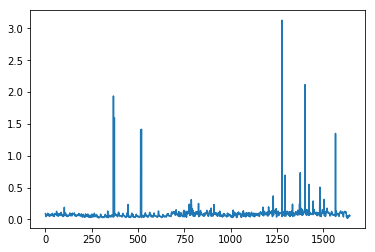

In [8]:
df.value.plot()

In [9]:
detector = RobustDetector(window=50)
df['anomaly_score'] = 0

In [10]:
import numpy as np
import time

In [11]:
%%time
times = np.zeros_like(df.value)
for ix, value in enumerate(df.value):
    now=time.time()
    tmp = detector.predict(value)
    times[ix] = time.time()-now
    df['anomaly_score'].iloc[ix] = tmp

CPU times: user 50.4 s, sys: 36.9 ms, total: 50.4 s
Wall time: 50.4 s


In [12]:
print(round(times.mean()*1e3, 3), 'ms')

0.288 ms


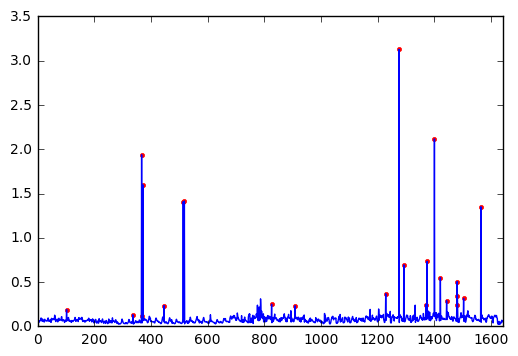

In [33]:
th=1
df[df['anomaly_score'] >= th]['value'].plot(style='r.')
df['value'].plot()

In [16]:
from streamz.dataframe import Random, DataFrame

In [17]:
source = Random(freq='5ms', interval='100ms')
source.x.sum()



Output()

In [18]:
sdf = (source - 0.5).cumsum()
sdf.tail()

Output()

In [22]:
p = (DataFrame({'raw': sdf.x,
                'smooth': sdf.x.rolling('1s').mean(),
                'very-smooth': sdf.x.rolling('500ms').mean()})
     .plot(width=700)
    )

Loading BokehJS ...